I'm going to try writing a 'flat ACF' method as described in Huber+09, Viani+19, and references therein. Just to see if it works better than what I currently have built into lightkurve.

In [1]:
import sys
sys.path.append('/home/oliver/PhD/Hacks_and_Mocks/')
import lightkurve as lk
print(lk.__version__)
import numpy as np
from astropy.units import cds
from astropy import units as u
import pylab as plt

1.1.dev


Lets get the data as we usually would

In [2]:
datalist = lk.search_lightcurvefile('16CygA',cadence='short')
data = datalist[3:4].download_all()
lc = data[0].PDCSAP_FLUX.normalize().flatten()
for nlc in data:
    lc = lc.append(nlc.PDCSAP_FLUX.normalize().flatten())
lc = lc.remove_nans()
pg = lc.to_periodogram(normalization='psd')
snr = pg.flatten()

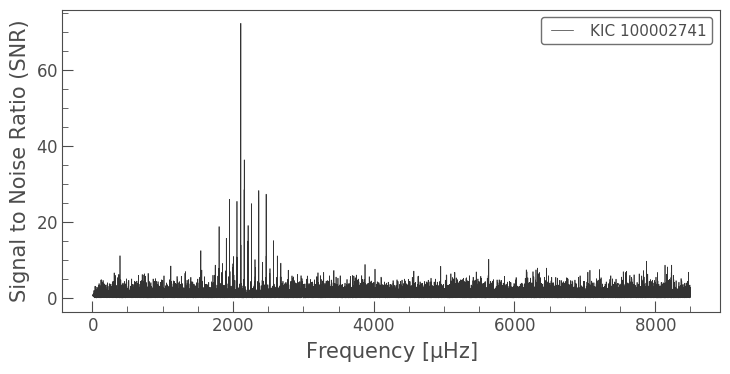

In [3]:
snr.plot()

Now lets construct the ACF, borrowing some code frome lk.periodogram

We calcualte the autocorrelation for a 25 $\mu$Hz wide window. The central frequency is moved forwards by 1 $\mu$Hz until we reach the end of the spectrum (presumeably, until the end of the spectrum is equal to the end of the window, so window width remains consistent).

This could be problematic for low-numax situations.

In [4]:
f = snr.frequency.value
p = snr.power.value
numaxs = np.arange(125, np.floor((f.max()))-125, 25.)

In [5]:
def autocorrelate(numax):
    fs = np.median(np.diff(f))
    spread = int(125/fs)
    x = int(numax / fs)                                 
    p_han = p[x-spread:x+spread]
    C = np.correlate(p_han, p_han, mode='full')         #Correlated the resulting SNR space with itself
    C = C[len(p_han)-1:]                                #Truncate the ACF
    return C    

In [6]:
fs = np.median(np.diff(f))
acf = np.zeros([len(numaxs), int(250./fs)])
for idx, numax in enumerate(numaxs):
    acf[idx,:] = autocorrelate(numax)

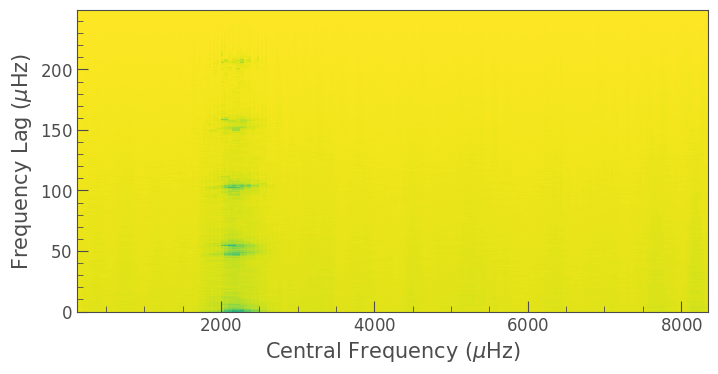

In [7]:
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    xs = numaxs
    ys = np.arange(int(250./fs)) * fs
#     plt.contourf(X, Y, acf.T, cmap='Blues_r')

    extent = (xs[0],xs[-1],ys[0],ys[-1])
    figsize = plt.rcParams['figure.figsize']
    a = figsize[1]/figsize[0]
    b = (extent[3]-extent[2])/extent[1]

    im = ax.imshow(acf.T, cmap='viridis_r', aspect=a/b, 
              origin='lower', extent=extent)
    ax.set_xlabel(r'Central Frequency ($\mu$Hz)')
    ax.set_ylabel(r'Frequency Lag ($\mu$Hz)')
#     fig.colorbar(im, label='ACF Strength')

Now let's calculated the MCC (Kiefer 2013)

In [8]:
mcc = np.ones_like(numaxs)
for idx, numax in enumerate(numaxs):
    mcc[idx] = (np.sum(np.abs(acf[idx])) - 1) / len(acf[idx])

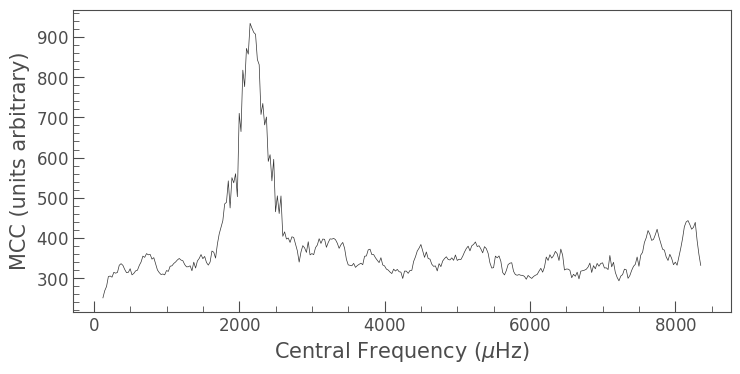

numax is 2150.0


In [9]:
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    ax.plot(numaxs, mcc)
    ax.set_xlabel(r'Central Frequency ($\mu$Hz)')
    ax.set_ylabel('MCC (units arbitrary)')
    plt.show()
print('numax is {}'.format(numaxs[np.argmax(mcc)]))

dnu is 103.37521515299613


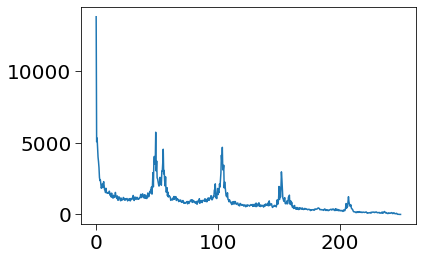

In [10]:
plt.plot(ys, autocorrelate(2141.))
print('dnu is {}'.format(ys[ys>80][np.argmax(autocorrelate(2141.)[ys>80])]))

## Now lets try the MCC method on the Hanning window

In [11]:
def _autocorrelate(numax):
    fs = np.median(np.diff(f))
    fwhm = int(np.floor(0.25*numax / fs))    # Express the fwhm in indices
    x = int(numax / fs)                                 #Find the index value of numax
    s = np.hanning(len(p[x-fwhm:x+fwhm]))      #Define the hanning window for the evaluated frequency space
    p_han = p[x-fwhm:x+fwhm] * s         #Multiply the evaluated SNR space by the hanning window
    C = np.correlate(p_han, p_han, mode='full')         #Correlated the resulting SNR space with itself
    C = C[len(p_han)-1:]                                #Truncate the ACF
    return C

numaxs_log = 10**np.linspace(np.log10(5), np.log10(f[-1]), 500)

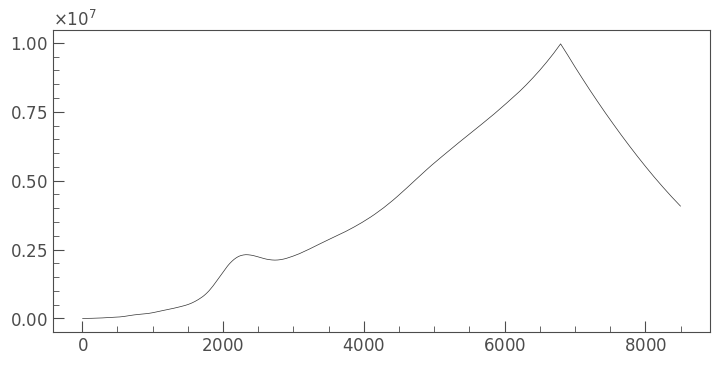

In [12]:
mccs = np.zeros(len(numaxs_log))
for idx, numax in enumerate(numaxs_log):
    acf = _autocorrelate(numax)      #Return the acf at this numax
    mccs[idx] = (np.sum(np.abs(acf))-1 / len(acf))

with plt.style.context(lk.MPLSTYLE):
    plt.plot(numaxs_log, mccs)

# That doesn't work as well... Now lets quickly compare the three:
- MCC using a flat ACF method
- Hanning ACF using a square root normalisation
- Null Hypothesis test with a 98% likelihood threshold

MCC with flat ACF:


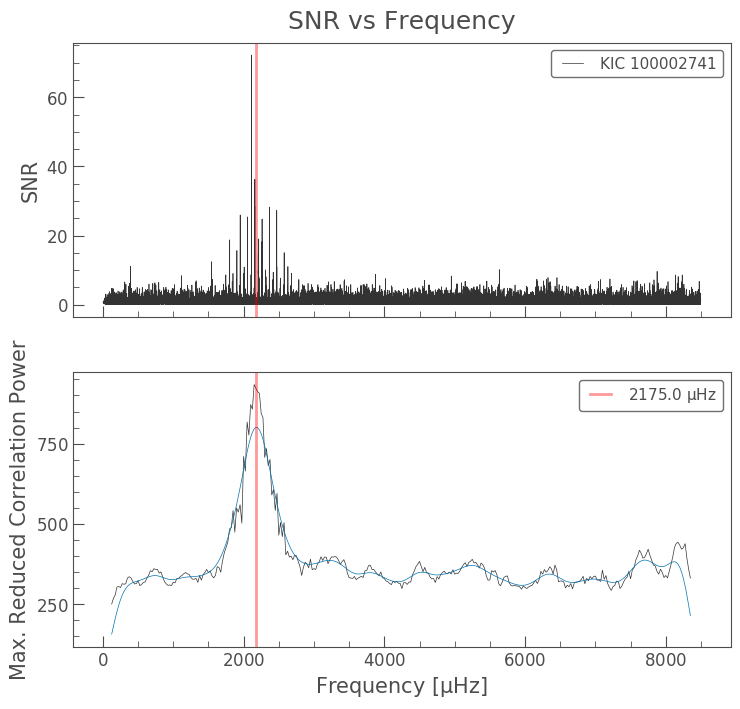

In [13]:
print('MCC with flat ACF:')
numax, _ = snr.estimate_numax(method='flat', show_plots=True)
# snr.plot()
# with plt.style.context(lk.MPLSTYLE):
#     fig, ax = plt.subplots()
#     ax.plot(numaxs, mcc)
#     ax.set_xlabel(r'Central Frequency ($\mu$Hz)')
#     ax.set_ylabel('MCC (units arbitrary)')
#     plt.show()

Hanning ACF with square root normalisation:


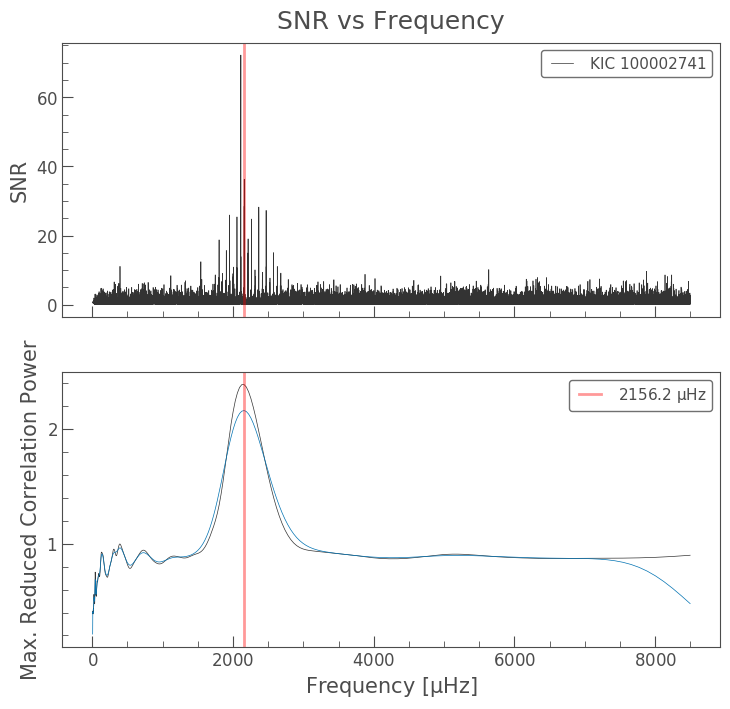

In [14]:
print('Hanning ACF with square root normalisation:')
numax, _ = snr.estimate_numax(show_plots=True, method='ACF')

Null Hypothesis test with 98% threshold


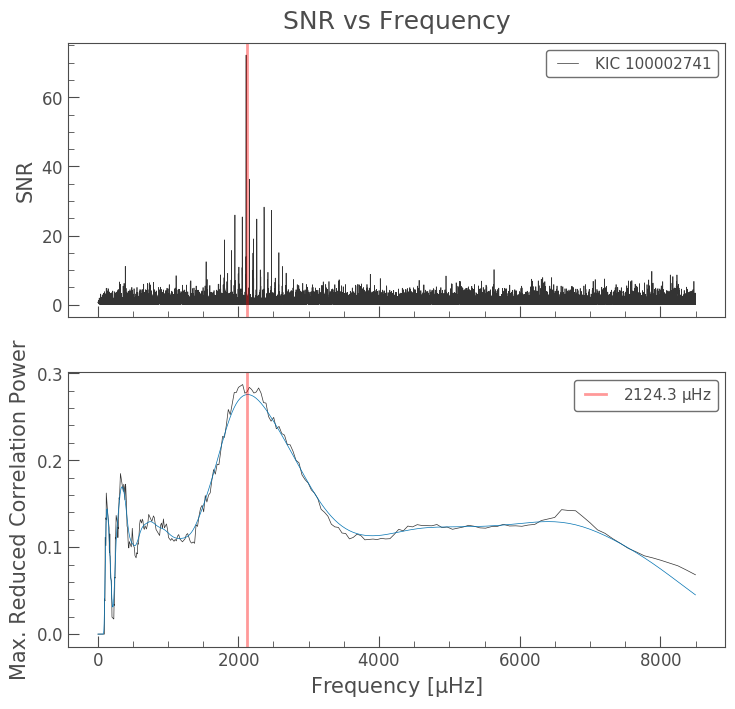

In [15]:
print('Null Hypothesis test with 98% threshold')
numax, _ = snr.estimate_numax(show_plots=True, method='H0')

# Conclusion:
I prefer the flat ACF for its improved range, but I would prefer the $\Delta\nu$ calculate to be done using a hanning window autocorrelation.

I'll need to implementation test the new options.